In [1]:
#Importing libs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from sklearn.decomposition import PCA

from sklearn.preprocessing import Normalizer
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import pickle

#setting theme for seaborn/matplotlib plots
sns.set()
sns.set_palette('hls')

In [2]:
#Creating Dataframe from csv data and cleaning

hep_data = pd.read_csv("HepatitisCdata.csv").drop("Unnamed: 0", axis=1)
y_data = hep_data["Category"]
X_data = pd.get_dummies(hep_data.drop("Category", axis=1))

hep_data = X_data.join(y_data)

In [3]:
#Classes
list(y_data.unique())

['0=Blood Donor',
 '0s=suspect Blood Donor',
 '1=Hepatitis',
 '2=Fibrosis',
 '3=Cirrhosis']

In [4]:
#Showing the data balance

y_data.value_counts()

0=Blood Donor             533
3=Cirrhosis                30
1=Hepatitis                24
2=Fibrosis                 21
0s=suspect Blood Donor      7
Name: Category, dtype: int64

In [5]:
#Categorical data to numerical, dropping suspect donors (only 7 entries)
hep_data = hep_data[hep_data["Category"] != "0s=suspect Blood Donor"].reset_index().drop("index", axis=1)
hep_data = hep_data.replace(list(hep_data["Category"].unique()),np.linspace(1,4,4))
X_data = hep_data.drop("Category", axis=1)
y_data = hep_data["Category"]

In [6]:
#Splitting sets in train, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size=0.25, random_state=32,
                                                    stratify=y_data)

In [7]:
#Counting NA values
X_train.isna().sum()

Age       0
ALB       1
ALP      14
ALT       1
AST       0
BIL       0
CHE       0
CHOL      8
CREA      0
GGT       0
PROT      1
Sex_f     0
Sex_m     0
dtype: int64

In [8]:
#Filling with np.nan for imputation
X_train.fillna(np.nan)

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Sex_f,Sex_m
188,49,41.2,96.0,25.0,27.7,15.6,7.12,5.61,92.0,37.8,68.7,0,1
271,59,38.4,61.2,15.9,27.2,3.0,6.88,6.89,91.0,14.0,64.5,0,1
263,58,44.0,56.0,30.6,33.0,4.8,12.37,6.33,74.0,58.7,75.8,0,1
476,53,43.7,84.3,18.8,18.6,8.5,10.22,6.65,56.0,16.5,76.9,1,0
493,56,34.7,90.3,22.7,21.6,3.5,8.07,5.45,67.0,9.0,69.4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,43,41.2,59.4,34.3,24.2,4.1,9.64,4.93,84.0,20.8,74.5,0,1
17,33,45.2,88.3,32.4,31.2,10.1,9.78,5.51,102.0,48.5,76.5,0,1
369,40,43.2,42.4,15.7,23.6,9.7,7.56,6.74,88.0,11.5,73.2,1,0
441,49,39.3,59.4,18.3,15.0,4.8,8.03,4.58,83.0,12.5,74.3,1,0


In [9]:
#Create data Imputer using Mean
imp = SimpleImputer(missing_values=np.nan, strategy="mean")

In [10]:
#Data Imputation
X_train = pd.DataFrame(imp.fit_transform(X_train), columns=list(X_train.columns))
X_test = pd.DataFrame(imp.transform(X_test),columns=list(X_train.columns))

In [11]:
#Create lasso model for variable selection with cross_validation parameter = 5 and multiple alphas using LassoCV
lasso_model = linear_model.LassoCV(cv=5,random_state=30)
lasso_model.fit(X_train,y_train)

LassoCV(cv=5, random_state=30)

In [12]:
#Return score (Determination Coefficient). Best=1, Worse=0.
lasso_model.score(X_train, y_train)

0.6217263729220899

In [13]:
#Show coefficient weigths
lasso_model.coef_

array([ 0.00480137, -0.01797585, -0.00275716,  0.00128478,  0.00899004,
        0.0083815 , -0.03407224, -0.04703574,  0.00253478,  0.00267948,
        0.01575848,  0.        , -0.        ])

In [14]:
#Creatting Dataframe for coefficient weigths
Coeff_data = pd.DataFrame(lasso_model.coef_).T
Coeff_data.columns = list(X_train.columns)

#Select most important weigths
columns_neg = Coeff_data.T.sort_values(0, ascending=True).index[0:4]
columns_pos = Coeff_data.T.sort_values(0, ascending=False).index[0:4]
columns_features = list(columns_neg) + list(columns_pos)
columns_features

['CHOL', 'CHE', 'ALB', 'ALP', 'PROT', 'AST', 'BIL', 'Age']

In [15]:
#Filter data to selected columns
X_train = X_train[columns_features]
X_test = X_test[columns_features]

In [16]:
#Normalize the data
X_train = pd.DataFrame(Normalizer().fit_transform(X_train),
                           columns=list(X_train.columns))
X_test = pd.DataFrame(Normalizer().transform(X_test),
                     columns=list(X_train.columns))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but Normalizer was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [17]:
#SAVING NORMALIZER PARAMETERS
norm = Normalizer()
pickle.dump(Normalizer, open("normalizer.sav", 'wb'))

In [18]:
#Dimensionality reduction with PCA
pca = PCA(n_components=2).fit(X_train)
X_train = pd.DataFrame(pca.transform(X_train))
X_test = pd.DataFrame(pca.transform(X_test))

In [19]:
#SAVING PCA PARAMETERS
pickle.dump(pca, open("pca_param.sav", 'wb'))

In [20]:
#Replace Classes to make a binary classification problem: all grade of hepatic disease vs healthy

y_train = y_train.replace([4.0,2.0,3.0],2)
y_test = y_test.replace([4.0,2.0,3.0],2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


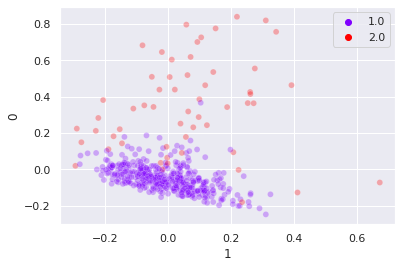

In [21]:
#Data looks linearly separable in two dimensions
sns.scatterplot(1,0, data=X_train, hue=list(y_train),
                palette='rainbow', alpha=0.3)

In [22]:
#Create Support Vector Machine Model, Fit and Accuracy Train Score, with defaults parameters,
#and accuracy score for the Train set
svm = SVC(gamma='auto')
svm.fit(X_train, y_train)
svm.score(X_train, y_train)

0.9473684210526315

In [23]:
#Predict for the Train set to see a Confusion Matrix

y_train_pred = svm.predict(X_train) 

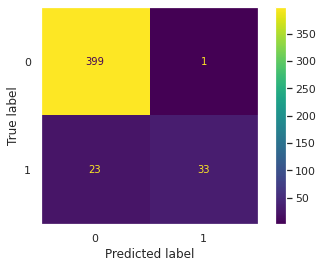

In [24]:
#Confusion Matrix
cm_hep = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(cm_hep).plot()
plt.grid(b=None)

In [25]:
#Classification Report for train data
print(classification_report(y_train, y_train_pred, target_names=["Healthy","Disease"]))
#The model indentifies with more accuracy Healthy subjects than sick ones (based on recall and f1-score)

              precision    recall  f1-score   support

     Healthy       0.95      1.00      0.97       400
     Disease       0.97      0.59      0.73        56

    accuracy                           0.95       456
   macro avg       0.96      0.79      0.85       456
weighted avg       0.95      0.95      0.94       456



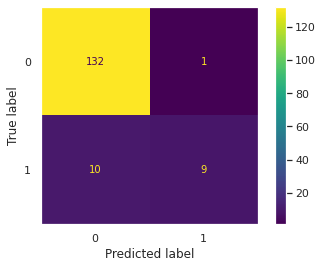

In [26]:
#The same for the Test Set
y_test_pred = svm.predict(X_test)

cm_hep = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm_hep).plot()
plt.grid(b=None)

In [27]:
#Metrics for Specificity vs Sensitivity metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

In [28]:
#Report for test data. Not overfitting, almost the same scores
print(classification_report(y_test, y_test_pred, target_names=["Healthy","Disease"]))

              precision    recall  f1-score   support

     Healthy       0.93      0.99      0.96       133
     Disease       0.90      0.47      0.62        19

    accuracy                           0.93       152
   macro avg       0.91      0.73      0.79       152
weighted avg       0.93      0.93      0.92       152



/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


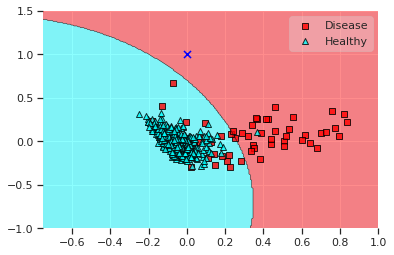

In [29]:
#Plot the decision region
from mlxtend.plotting import plot_decision_regions

xdataplot = np.array(X_train)
ydataplot = np.reshape(np.array(-y_train.astype("int64")), newshape=(456,),)



ax = plot_decision_regions(xdataplot, ydataplot, clf=svm, legend=1,colors="red,cyan")
handles, labels = ax.get_legend_handles_labels()
ay = plt.scatter(0.0,1.0, c="blue", marker="x", s=50, label="your point")


ax.legend(handles, 
          ['Disease', 'Healthy'], 
           framealpha=0.3, scatterpoints=1)

plt.xlim(-0.75, 1)
plt.ylim(-1, 1.5)
plt.show()

In [30]:
#Saving points for decision region
xpoints = xdataplot , ydataplot
pickle.dump(xpoints, open("xpoints.sav", 'wb'))

In [31]:
#Save the model

pickle.dump(svm, open("svm_hepatitis.sav", 'wb'))